#### Training a convultional neural network to estimate selection coefficients
#### Seth Temple, sdtemple.github.io
#### 2/19/2025

A decent amount of code is Copy + Paste and modify from: 

https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb


To do:
- Figure expressing uncertainty in selection coefficient estimation
- Train the neural network with a convolutional layer
- Train the neural networks on Great Lakes cluster

In [49]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from simple_selcoef import * # must be in same folder
from math import floor, ceil
plt.rc('font',size=14)

In [ ]:
# two layer simple neural network
class L2NN(nn.Module):
    def __init__(self,
                 number_output,
                 number_input,
                 number_hidden,
                 ):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(number_input, number_hidden),
            # nn.Dropout(),
            nn.ReLU(),
            nn.Linear(number_hidden, number_hidden),
            # nn.Dropout(),
            nn.ReLU(),
            nn.Linear(number_hidden, number_output),
        )

    def forward(self, x):
        x = self.flatten(x)
        fitted = self.linear_relu_stack(x)
        return fitted

In [42]:
# fully connected neural network
# From Mosely GitHub tutorial
# Hence the M in MFNN
# flexible activations, layers
# Sequential class only
class MFNN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, activation):
        super().__init__()
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
# two layer convolutional neural network
class L2CNN(nn.Module):
    def __init__(self,
                 number_output,
                 number_input,
                 number_channels,
                 number_hidden,
                 kernel_size,
                 stride,
                 ):
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_relu_stack = nn.Sequential(
            nn.Conv1d(in_channels=number_channels, 
                      out_channels=number_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      ),
            # nn.MaxPool1d(kernel_size=int(kernel_size/2),
            #              stride=ceil(stride/2),
            #              ),
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(number_input-2, number_hidden),
            # nn.Dropout(),
            nn.ReLU(),
            nn.Linear(number_hidden, number_hidden),
            # nn.Dropout(),
            nn.ReLU(),
            nn.Linear(number_hidden, number_output),
        )

    def forward(self, x):
        fitted = self.cnn_relu_stack(x)
        return fitted

#### Training the model

In [98]:
### Neural networks parameters
num_epochs = 40
num_batches = 1000
num_hidden = 64
# mosely flexible fully connected
mosely_num_layers = 4
mosely_act = nn.ReLU
# 1d convolutional
kernel_size = 3
stride_size = 1
number_channels = 1


In [118]:
# rename data files if applicable
x_data = torch.load('x_train_shuffled.pth')
y_data = torch.load('y_train_shuffled.pth')

/tmp/ipykernel_3071/1038600882.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_data = torch.load('x_train_shuffled.pth')
/tmp/ipykernel_3071/1038600882.py:3: FutureWar

In [ ]:
# Train a two layer neural network
torch.manual_seed(123)
dataset = TensorDataset(x_data,y_data)
dataloader = DataLoader(dataset, batch_size=num_batches, shuffle=True)
simple_model = L2NN(1,
                    gens.shape[0],
                    num_hidden,
                   )
optimizer = torch.optim.Adam(simple_model.parameters(),lr=1e-3)
files = []
for i in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        yh = simple_model(inputs)
        loss = torch.mean((yh-targets)**2)# use mean squared error
        loss.backward()
        optimizer.step()
            

In [ ]:
# Train the standard Mosely neural network
# I will double the number of layers
torch.manual_seed(456)
dataset = TensorDataset(x_data,y_data)
dataloader = DataLoader(dataset, batch_size=num_batches, shuffle=True)
mosely_model = MFNN(gens.shape[0],
                   1,
                   num_hidden,
                   mosely_num_layers,
                   mosely_act)
optimizer = torch.optim.Adam(mosely_model.parameters(),lr=1e-3)
files = []
for i in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        yh = mosely_model(inputs)
        loss = torch.mean((yh-targets)**2)# use mean squared error
        loss.backward()
        optimizer.step()
            

In [ ]:
# Train a neural network with a convolutional layer
torch.manual_seed(789)
dataset = TensorDataset(x_data[:,None,:],
                        y_data[:,None,:])
dataloader = DataLoader(dataset, batch_size=num_batches, shuffle=True)
conv1d_model = L2CNN(1,
                    gens.shape[0],
                    1,
                    num_hidden,
                    kernel_size,
                    stride_size,
                   )
optimizer = torch.optim.Adam(conv1d_model.parameters(),lr=1e-3)
files = []
for i in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        yh = conv1d_model(inputs)
        loss = torch.mean((yh-targets)**2)# use mean squared error
        loss.backward()
        optimizer.step()
            

In [120]:
# Save the standard model
torch.save(mosely_model, 'mosely-model.pth')
torch.save(simple_model, 'simple-model.pth')
torch.save(conv1d_model, 'conv-model.pth')

#### Model evaluation

/tmp/ipykernel_3071/516378869.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_test = torch.load('x_test.pth')
/tmp/ipykernel_3071/516378869.py:4: FutureWarning: You ar

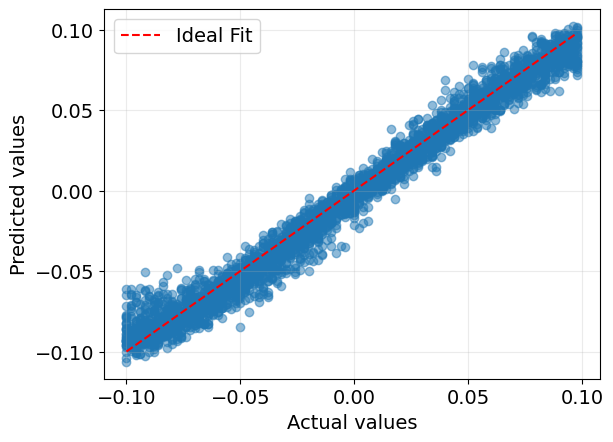

In [ ]:
# load in data and model
# predict on testing data
x_test = torch.load('x_test.pth')
y_test = torch.load('y_test.pth')

# saved_model = torch.load('mosely-model.pth')
# y_pred = saved_model(x_test)
saved_model = torch.load('simple-model.pth')
y_pred = saved_model(x_test)

# saved_model = torch.load('conv-model.pth')
# y_pred = saved_model(x_test[:,None,:])

plot_scatter_pred(y_pred,y_test,1.)

In [124]:
# Simulation data
sample_size = 50
gens = np.arange(0,50,2)
sizes = np.repeat(sample_size, gens.shape[0])
Ne = read_Ne('c10.ne')

In [129]:
# compute a bootstrap interval
# mainly expresses wright-fisher uncertainty
l,u=bootstrap_interval(saved_model,250,0.0,0.20,Ne,gens,sizes)
u-l,u,l

(0.021462723519653084, 0.007626872975379231, -0.013835850544273854)